In [2]:
using Images
using Statistics
using Plots
using DSP
using StatsBase

In [1]:
function mask_site(file; n_sites=1)
    img = load(file)
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    # Do frame averaging
    im_array = im_array ./ frame_avg
    # Do mean value subtraction
    im_array = im_array .- mean(im_array)
    # Use stack sum projection to find polarity patch(es)
    avgimg = mean(im_array, dims=(3))[:,:,1]
    max_bin = 0
    threshold = 0.55
    bin = avgimg .> maximum(avgimg)*threshold
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin             # Half max of average is used as threshold
        max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
        max_lab = bin_lab[max_loc]                  
        max_bin = bin_lab .== max_lab               # Make mask only around correct component
        im_masked = im_array .* max_bin
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [11]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    start = Integer(findall(signal .> (maximum(signal))*thresh)[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        print(".")
        last = length(signal)
        times = last-Integer(frames):last
        return times
    end
end

crop_times (generic function with 1 method)

In [8]:
max(5:60, 4:59)

5:60

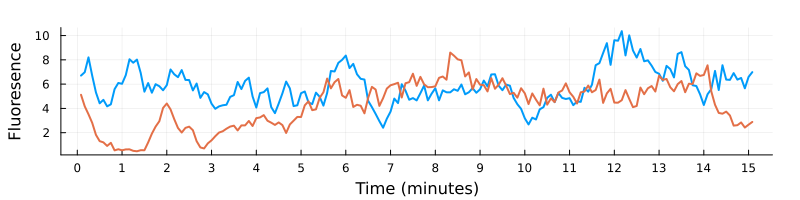

In [119]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell2.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
t = range(1,length(crop1))*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, linewidth=2, xlabel="Time (minutes)", label=false,
    ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, xticks=0:1:15)
plot!(t, crop2, linewidth=2, color=2, label=false)
#savefig("../figures/2patch_trace_2_4.png")

In [120]:
max(times_max1, times_max2)

73:253

.

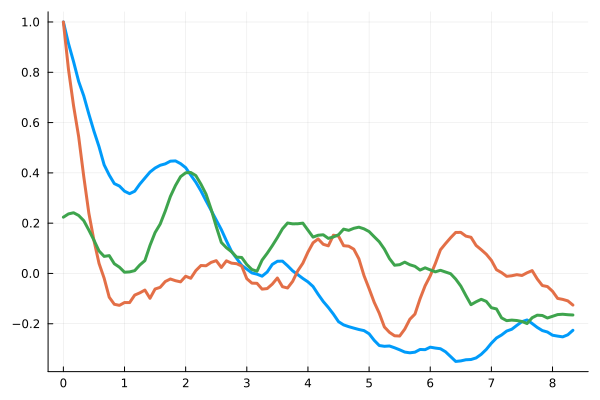

In [159]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell1.tif" # bad. polarizes at very end of movie. 
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
ac1 = crosscor(crop1, crop1, 0:100)
ac2 = crosscor(crop2, crop2, 0:100)
xcor = crosscor(crop1, crop2, 0:100)
n+=2
t_cor = range(0,100)*(5/60)
plot(t_cor, ac1, x_ticks=0:8, label=false, color=1, linewidth=3)
plot!(t_cor, ac2, x_ticks=0:8, label=false, color=2, linewidth=3)
plot!(t_cor, xcor, x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/2patch_ac_2_4.png")

.

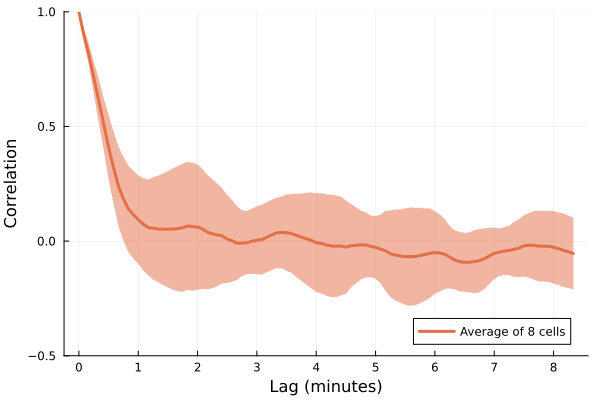

In [152]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files))
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:100)
    n+=1
    all_cor[:,n] = cor1
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color=2, alpha=1, label="Average of $(Int(n)) cells", ylim=(-0.5,1))

.

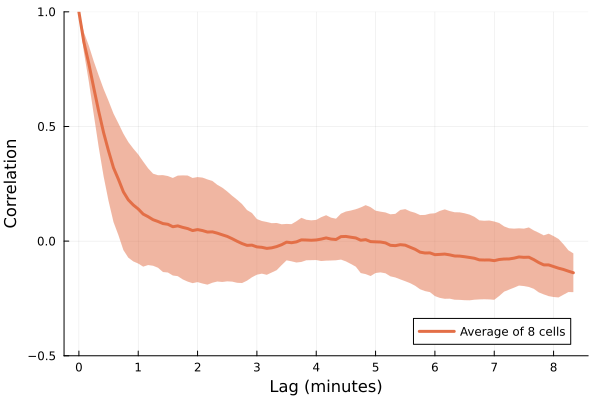

In [153]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files))
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor2 = crosscor(crop2, crop2, 0:100)
    n+=1
    all_cor[:,n] = cor2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color=2, alpha=1, label="Average of $(Int(n)) cells", ylim=(-0.5,1))

.

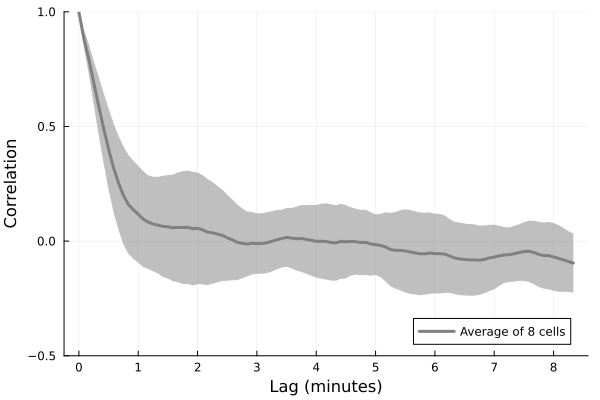

In [150]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files)*2)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:100)
    cor2 = crosscor(crop2, crop2, 0:100)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))

..

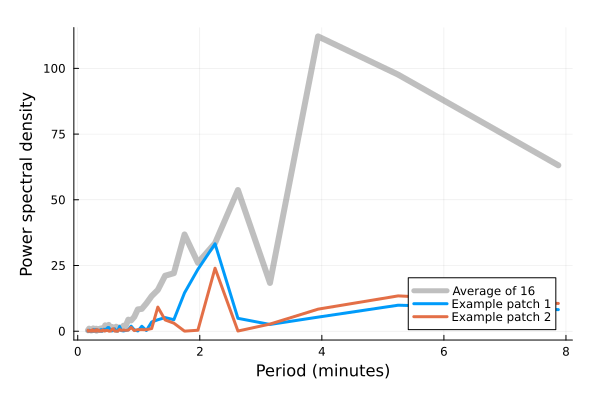

In [115]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
max_powers = zeros(95)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    pdg_max1 = DSP.Periodograms.periodogram(crop1)
    pdg_max2 = DSP.Periodograms.periodogram(crop2)
    max_powers = max_powers .+ pdg_max1.power
    max_powers = max_powers .+ pdg_max2.power
    frequencies = pdg_max1.freq
    global frequencies
    n+=2
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = false, 
    label="Average of $n", linewidth=6, alpha=0.5, margin=5Plots.mm, color="grey")

file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
pdg_max1 = DSP.Periodograms.periodogram(crop1)
pdg_max2 = DSP.Periodograms.periodogram(crop2)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max1.power[3:end], xflip = false, 
    label="Example patch 1", linewidth=3, alpha=1, margin=5Plots.mm, color=1)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max2.power[3:end], xflip = false, 
    label="Example patch 2", linewidth=3, alpha=1, margin=5Plots.mm, color=2)
#savefig("../figures/2patch_periodogram_2_4.png")

In [71]:
pos_max = findmax(all_cor)[2]*(5/60)

2.833333333333333

.

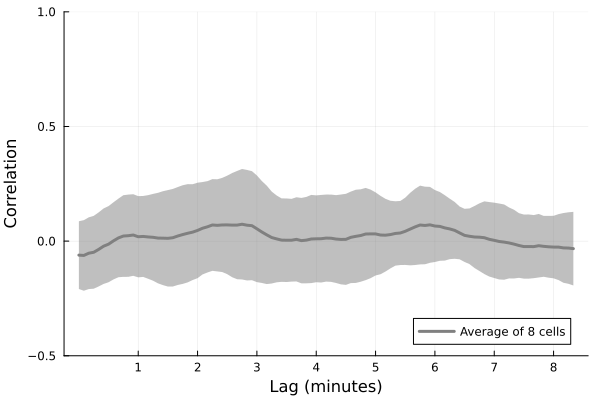

In [151]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files)*2)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop2, -100:0)
    cor2 = crosscor(crop1, crop2, 0:100)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))

In [131]:
mean(all_cor, dims=2)

101×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

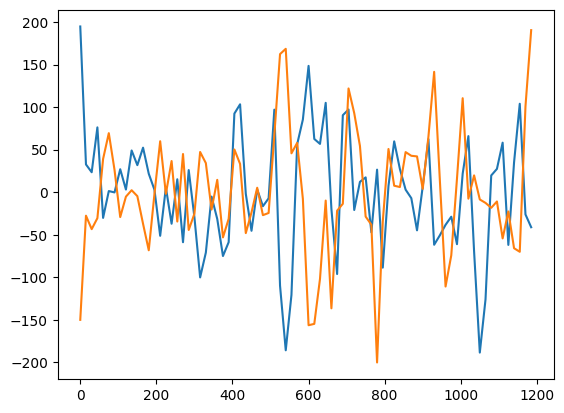

In [102]:
plt.plot(t, highpass01, t, highpass02)

In [103]:
np.corrcoef(highpass01,highpass02)[0,1]

-0.3350724194901477